## Task: design the quantum walk operator for the case of a line with 16 nodes

#### 1. Firstly, let us plot the path graph with 16 nodes

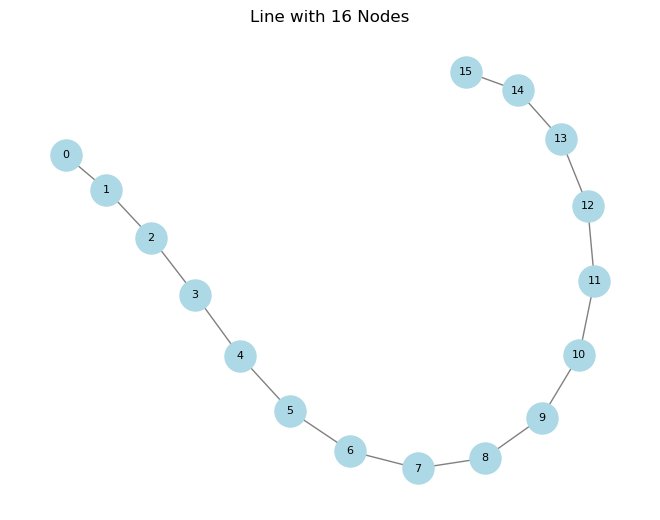

In [16]:
### import the necessary library
import networkx as nx
import matplotlib.pyplot as plt

# Creating the path graph with 16 nodes
G = nx.path_graph(16)

# Plot the graph
pos = nx.spring_layout(G)  # Position nodes using a spring layout algorithm
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=8, edge_color='gray')

# Add a title and display the plot
plt.title("Line with 16 Nodes")
plt.show()

#### 2. Next, we design the quantum walk algorithm for this graph

Generally, the Quantum walk algorithm consist of 2 fundamental components: the C operator and the S operator.

$$ C=\sum_{j\in V}^{N} \left| j\right\rangle \left\langle j\right|  \otimes \left( 2 \left| \partial_j\right\rangle \left\langle \partial_j\right| - I\right)$$  in which $\left( 2 \left| 0_j\right\rangle \left\langle 0_j\right| - I\right)$ is the diffuzer operator and 

$$S=\sum_{(j,k)\in E}^{n} \left| j,k\right\rangle \left\langle j,k\right| $$

were V is the set of vertices (0,1,2....,15), E the set of edges, n the total number of edge and N the total number of vertices.

Here, we will show how to encode the C and the S operators for our specific path graph with 16 nodes.

In [17]:
from classiq import*

In [19]:
## defining the number of qubits we will use to encode the 16 nodes
size = 4

#### Implementing the C operator

In [20]:
### first implement the diffuzer zero (the phase kickback)

#function to prepare the target qubit in the minus state
@qfunc
def prepare_minus(x: QBit):
  X(x)
  H(x)
    
#function to apply the diffuzer operation
@qfunc
def diffuzer_oracle(aux: Output[QNum],x:QNum):
  aux^=(x!=0)

# the full diffuzer zero function
@qfunc
def zero_diffuzer(x: QNum):
  aux = QNum('aux')
  allocate(1,aux)
  within_apply(compute=lambda: prepare_minus(aux),
              action=lambda: diffuzer_oracle)

In [21]:
############## Implementing the full C operator ******************************

#iterating over all the vertices and the adjacent vertices
def C_iteration(i:int,vertices: QNum, adjacent_vertices:QNum):
    prob = [0] * 16 #initializing the probability state
    
    #node 0 is adjacent to node 1 and the degree of node 0 is 1 so, state0=(1/deg(0))(|1>)=[0,1,0,...,0]
    if i == 0:
        prob[1] = 1
        
    #node 15 is adjacent to node 14 and the degree of node 15 is 1 so, state15=(1/deg(15))(|14>)=[0,..,0,1,0]
    elif i == 15:
        prob[14] = 1
        
    # for the rest of the nodes, they have deg 2 each and are each connected to their neighbors (i+1) and (i-1)
    else:
        prob[(i + 1) % 16] = 0.5
        prob[(i - 1) % 16] = 0.5
    print(f'State={i}, prob vec ={prob}') #print to see all the probality states
    
    #now, conditionned on each vertex, apply the diffuzer operator
    control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action= lambda: zero_diffuzer(adjacent_vertices)))

#### function to return the C operator (applied 16 times)
@qfunc 
def C_operator(vertices:QNum, adjacent_vertices: QNum):
    for i in range(2**size):
      C_iteration(i,vertices,adjacent_vertices)


In [24]:
####### Full Implementation of the S operator ##########

## first implement the edge oracle function that will produce a result only if sum of two vertices is 
#odd (Showing and edge), except for the sum of 0 and 15 that are not connected.                 
@qfunc
def edge_oracle(res: Output[QBit], vertices: QNum, adjacent_vertices: QNum):
    res |= (((vertices + adjacent_vertices) % 2) == 1) & ~((vertices == 0) & (adjacent_vertices == 15))
    
## Function implementing the bitwise swap to consider the symetry in edges
@qfunc 
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
  repeat(count= x.len,
    iteration= lambda i: SWAP(x[i],y[i]))
  
##implementing the S operator
@qfunc 
def S_operator(vertices:QNum, adjacent_vertices: QNum):
    res = QNum('res')
    edge_oracle(res,vertices,adjacent_vertices)
    control(ctrl= res==1,
        operand= lambda: bitwise_swap(vertices,adjacent_vertices))

In [25]:
#### Lastly, join all the part to design the quantum walk algorithm that consist of applying CS 16 times

@qfunc 
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):

  allocate(size,vertices)
  hadamard_transform(vertices)
  allocate(size,adjacent_vertices)

  C_operator(vertices,adjacent_vertices)
  S_operator(vertices,adjacent_vertices)

In [27]:
###create,synthetize and view the quantum program for the quantum walk algorithm of a path graph with 16 nodes
    #and the different probability states

qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

State=0, prob vec =[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=1, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=2, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=3, prob vec =[0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=4, prob vec =[0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=5, prob vec =[0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=6, prob vec =[0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
State=7, prob vec =[0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
State=8, prob vec =[0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
State=9, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
State=10, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
State=11, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
State=12, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0]
State=13, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 

The sinthetized quantum program is:
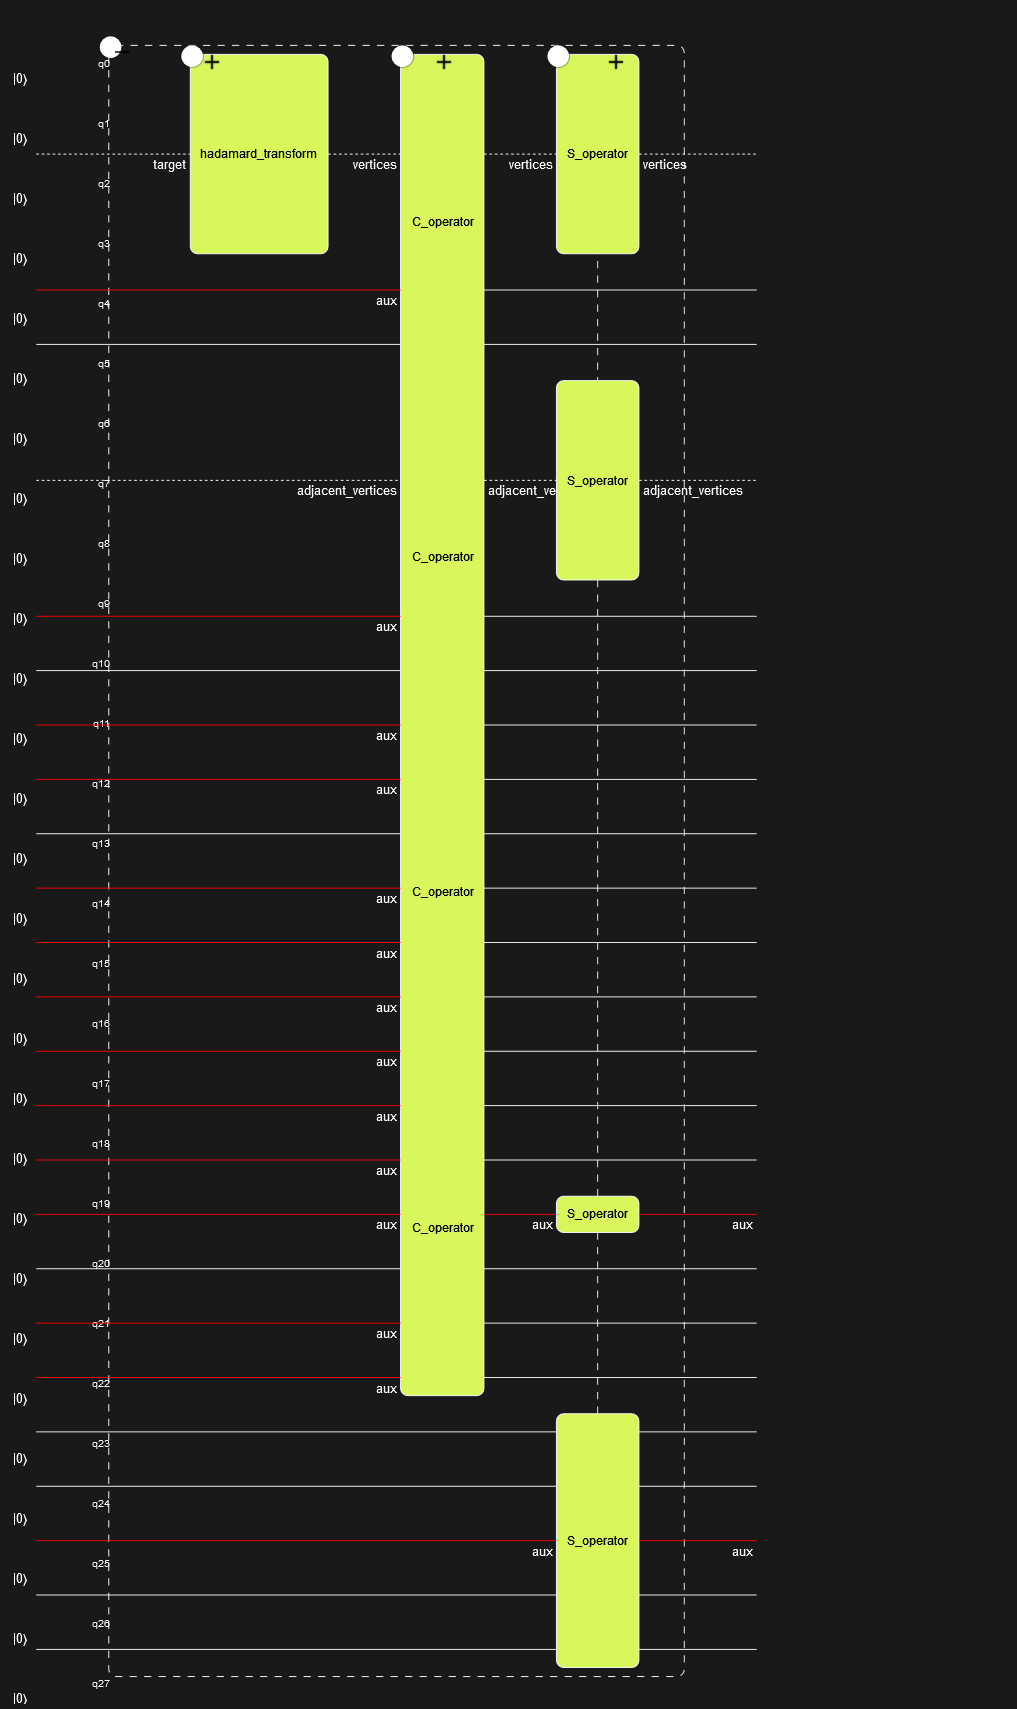